# Dual Model Pipeline dengan Feature Engineering

Notebook ini untuk **bearing failure prediction** dengan 2 model:
1. **Classification Model**: Memprediksi apakah bearing akan segera gagal (will_fail_soon)
2. **Regression Model**: Memprediksi berapa menit lagi sebelum failure (minutes_to_failure)

Kedua model menggunakan **feature engineering** lengkap dalam pipeline .pkl

## 1. Import Libraries

In [9]:
import json
import warnings
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import dump, load

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    RandomForestRegressor,
    GradientBoostingRegressor,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    f1_score,
    precision_recall_fscore_support,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import TimeSeriesSplit, train_test_split, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Custom Feature Engineering Transformer

In [10]:
class TimeSeriesFeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Custom transformer untuk feature engineering time series data.
    """
    
    def __init__(self, feature_cols=None, rolling_windows=[3, 5, 10], 
                 lag_periods=[1, 2, 3], create_interactions=True, create_diffs=True):
        self.feature_cols = feature_cols
        self.rolling_windows = rolling_windows
        self.lag_periods = lag_periods
        self.create_interactions = create_interactions
        self.create_diffs = create_diffs
        self.engineered_feature_names_ = []
    
    def fit(self, X, y=None):
        if self.feature_cols is None:
            if isinstance(X, pd.DataFrame):
                self.feature_cols = X.select_dtypes(include=[np.number]).columns.tolist()
            else:
                raise ValueError("feature_cols harus dispesifikasi jika X bukan DataFrame")
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_cols)
        
        X_eng = X.copy()
        
        # 1. Rolling Statistics
        for col in self.feature_cols:
            if col not in X_eng.columns:
                continue
            for window in self.rolling_windows:
                X_eng[f'{col}_rolling_mean_{window}'] = X_eng[col].rolling(window=window, min_periods=1).mean()
                X_eng[f'{col}_rolling_std_{window}'] = X_eng[col].rolling(window=window, min_periods=1).std().fillna(0)
                X_eng[f'{col}_rolling_min_{window}'] = X_eng[col].rolling(window=window, min_periods=1).min()
                X_eng[f'{col}_rolling_max_{window}'] = X_eng[col].rolling(window=window, min_periods=1).max()
        
        # 2. Lag Features
        for col in self.feature_cols:
            if col not in X_eng.columns:
                continue
            for lag in self.lag_periods:
                X_eng[f'{col}_lag_{lag}'] = X_eng[col].shift(lag).fillna(method='bfill')
        
        # 3. Rate of Change
        if self.create_diffs:
            for col in self.feature_cols:
                if col not in X_eng.columns:
                    continue
                X_eng[f'{col}_diff'] = X_eng[col].diff().fillna(0)
                X_eng[f'{col}_pct_change'] = X_eng[col].pct_change().fillna(0).replace([np.inf, -np.inf], 0)
        
        # 4. Interaction Features
        if self.create_interactions and len(self.feature_cols) > 1:
            for i, col1 in enumerate(self.feature_cols):
                if col1 not in X_eng.columns:
                    continue
                for col2 in self.feature_cols[i+1:]:
                    if col2 not in X_eng.columns:
                        continue
                    X_eng[f'{col1}_x_{col2}'] = X_eng[col1] * X_eng[col2]
        
        self.engineered_feature_names_ = list(X_eng.columns)
        return X_eng
    
    def get_feature_names_out(self, input_features=None):
        return np.array(self.engineered_feature_names_)

print("✓ TimeSeriesFeatureEngineer class defined")

✓ TimeSeriesFeatureEngineer class defined


## 3. Load dan Prepare Data

In [11]:
# Load data
df = pd.read_csv('bearing_failure_data_bearing1_only.csv', skipinitialspace=True)
df.columns = [str(c).strip() for c in df.columns]

# Parse timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.sort_values('timestamp').reset_index(drop=True)
df['is_failure'] = df['is_failure'].astype(str).str.strip().str.strip('"')

# Convert numeric columns
numeric_cols = ['mean_bearing_1', 'std_bearing_1', 'max_bearing_1', 'min_bearing_1']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"Dataset shape: {df.shape}")
print(f"\nLabel distribution:")
print(df['is_failure'].value_counts())
df.head()

Dataset shape: (984, 6)

Label distribution:
is_failure
N    983
Y      1
Name: count, dtype: int64


,timestamp,mean_bearing_1,std_bearing_1,max_bearing_1,min_bearing_1,is_failure
0,2004-02-12 10:32:39,-0.010196,0.073475,0.454,-0.386,N
1,2004-02-12 10:42:39,-0.002585,0.075338,0.369,-0.388,N
2,2004-02-12 10:52:39,-0.002484,0.076189,0.503,-0.400,N
3,2004-02-12 11:02:39,-0.002277,0.078691,0.608,-0.576,N
4,2004-02-12 11:12:39,-0.002404,0.078437,0.391,-0.391,N


## 4. Create Target Variables

Buat 2 target:
1. **minutes_to_failure**: Regresi - berapa menit lagi sebelum failure
2. **will_fail_soon**: Klasifikasi - apakah akan gagal dalam N menit

In [12]:
# Get failure timestamp
failure_rows = df[df['is_failure'] == 'Y']
if len(failure_rows) > 0:
    failure_timestamp = failure_rows['timestamp'].iloc[0]
    print(f"Failure timestamp: {failure_timestamp}")
else:
    raise ValueError("No failure found in dataset!")

# Calculate minutes to failure
df['minutes_to_failure'] = (failure_timestamp - df['timestamp']).dt.total_seconds() / 60.0
df['minutes_to_failure'] = df['minutes_to_failure'].clip(lower=0)

# Create classification target (will fail in next 300 minutes)
pre_failure_window = 300  # minutes
df['will_fail_soon'] = (df['minutes_to_failure'] <= pre_failure_window).astype(int)

print(f"\nMinutes to failure - Stats:")
print(df['minutes_to_failure'].describe())
print(f"\nWill fail soon distribution:")
print(df['will_fail_soon'].value_counts())

Failure timestamp: 2004-02-19 06:22:39

Minutes to failure - Stats:
count     984.000000
mean     4915.000000
std      2842.006334
min         0.000000
25%      2457.500000
50%      4915.000000
75%      7372.500000
max      9830.000000
Name: minutes_to_failure, dtype: float64

Will fail soon distribution:
will_fail_soon
0    953
1     31
Name: count, dtype: int64


## 5. Visualize Targets

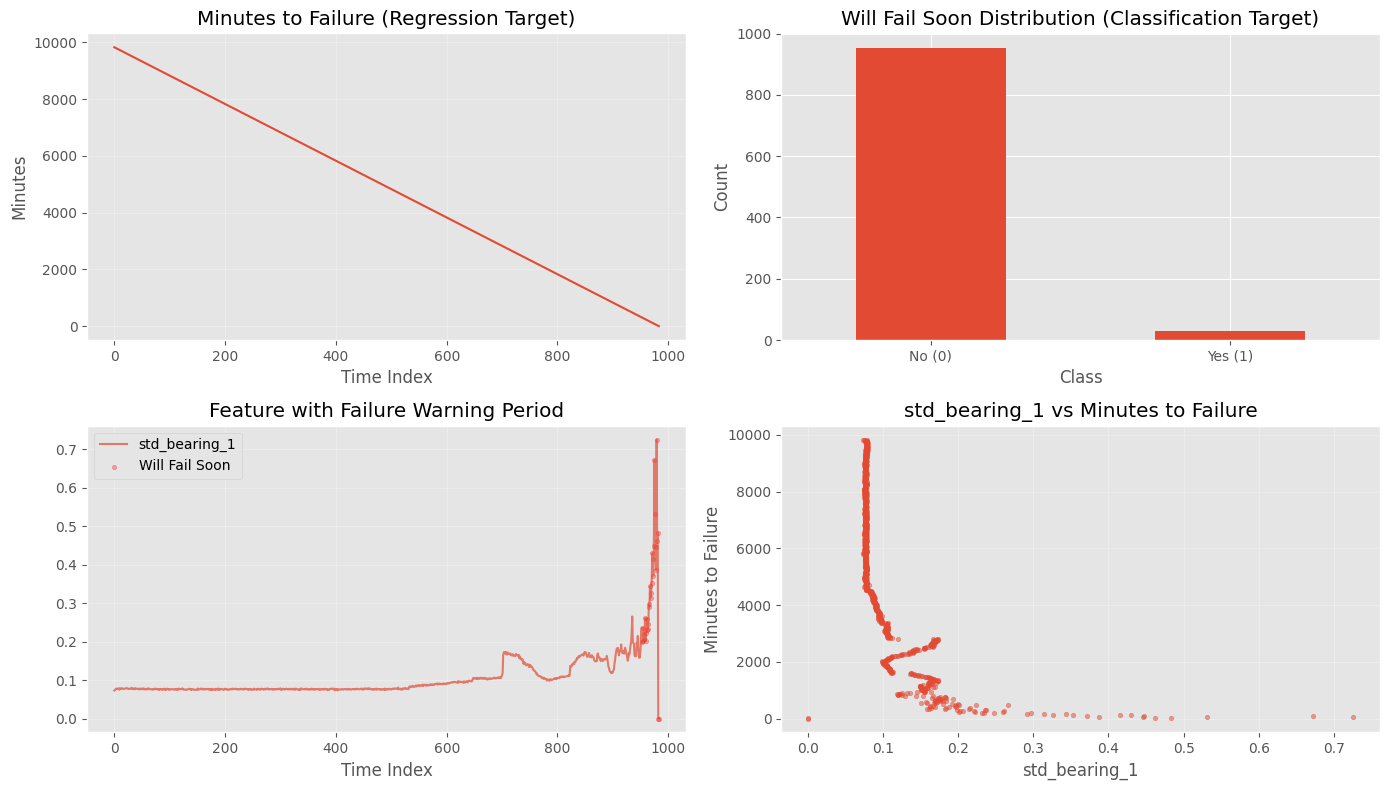

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Plot 1: Minutes to failure
axes[0, 0].plot(df.index, df['minutes_to_failure'])
axes[0, 0].set_title('Minutes to Failure (Regression Target)')
axes[0, 0].set_xlabel('Time Index')
axes[0, 0].set_ylabel('Minutes')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Will fail soon distribution
df['will_fail_soon'].value_counts().plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Will Fail Soon Distribution (Classification Target)')
axes[0, 1].set_xlabel('Class')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xticklabels(['No (0)', 'Yes (1)'], rotation=0)

# Plot 3: Feature over time with failure indicator
axes[1, 0].plot(df.index, df['std_bearing_1'], label='std_bearing_1', alpha=0.7)
failure_soon_idx = df[df['will_fail_soon'] == 1].index
axes[1, 0].scatter(failure_soon_idx, df.loc[failure_soon_idx, 'std_bearing_1'],
                   color='red', s=10, alpha=0.3, label='Will Fail Soon')
axes[1, 0].set_title('Feature with Failure Warning Period')
axes[1, 0].set_xlabel('Time Index')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Minutes to failure vs feature
axes[1, 1].scatter(df['std_bearing_1'], df['minutes_to_failure'], alpha=0.5, s=10)
axes[1, 1].set_title('std_bearing_1 vs Minutes to Failure')
axes[1, 1].set_xlabel('std_bearing_1')
axes[1, 1].set_ylabel('Minutes to Failure')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()